In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
batch_size=100
learning_rate=1e-3
epochs=100
# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# Data loader (input pipeline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [3]:
class ae(nn.Module):
    def __init__(self):
        super(ae,self).__init__()
        self.layer1=nn.Sequential(
            nn.Linear(784,200),
            nn.Sigmoid()
        )
        self.layer2=nn.Sequential(
            nn.Linear(200,784),
            nn.Sigmoid()
        )
    def forward(self,x):
        x=x.view(batch_size,-1)
        out=self.layer1(x)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out=out.view(batch_size,-1,28,28)
        
        return out
 

In [4]:

class CNN_AutoEncoder(nn.Module):
    def __init__(self):
        super(CNN_AutoEncoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(16,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2,2)
                        
        )
        self.layer2=nn.Sequential(
                        nn.ConvTranspose2d(32,16,kernel_size=3,stride=2,
                                           padding=1,output_padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,3,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(3),
                        nn.ConvTranspose2d(3,1,3,1,1),
                        nn.ReLU()
        )
                
    def forward(self,x):
        out = self.layer1(x)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        return out
    


In [5]:
encoder = CNN_AutoEncoder().cuda()
loss_fun=nn.MSELoss()
optimizer=torch.optim.Adam(encoder.parameters(),lr=learning_rate)
noise = torch.rand(batch_size,1,28,28)

In [6]:
#trainging phase
if(os.path.isfile('./saved_data/denoising_cnn_model.ckpt')==True):
    print("--------------load saved data--------------")
    encoder.load_state_dict(torch.load('./saved_data/denoising_cnn_model.ckpt'))
for i in range(epochs):
    for j , [image,ld] in enumerate(train_loader):
        image_n=torch.mul(image,noise)
        image=Variable(image).cuda()
        image_n=Variable(image_n).cuda()
#         print(image.shape)
        optimizer.zero_grad()
        output=encoder(image_n)
        loss=loss_fun(output,image)
        loss.backward()
        optimizer.step()
    if(i%10==0):
        print("epochs : ",i,", loss : ",loss)
print("learning finished ! \nsaved data")
torch.save(encoder.state_dict(), './saved_data/denoising_cnn_model.ckpt')


epochs :  0 , loss :  tensor(1.00000e-03 *
       6.4858, device='cuda:0')
epochs :  10 , loss :  tensor(1.00000e-03 *
       4.2048, device='cuda:0')
epochs :  20 , loss :  tensor(1.00000e-03 *
       4.1657, device='cuda:0')
epochs :  30 , loss :  tensor(1.00000e-03 *
       3.6866, device='cuda:0')
epochs :  40 , loss :  tensor(1.00000e-03 *
       4.1202, device='cuda:0')
epochs :  50 , loss :  tensor(1.00000e-03 *
       3.9250, device='cuda:0')
epochs :  60 , loss :  tensor(1.00000e-03 *
       3.9417, device='cuda:0')
epochs :  70 , loss :  tensor(1.00000e-03 *
       3.8354, device='cuda:0')
epochs :  80 , loss :  tensor(1.00000e-03 *
       3.6603, device='cuda:0')
epochs :  90 , loss :  tensor(1.00000e-03 *
       3.4883, device='cuda:0')


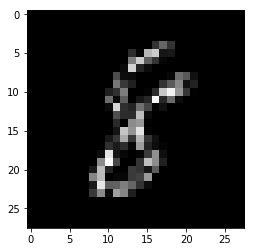

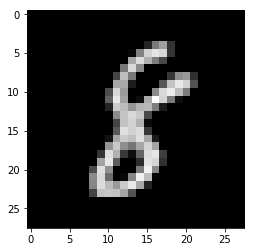

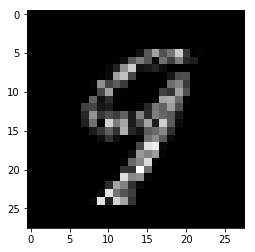

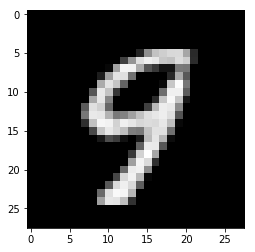

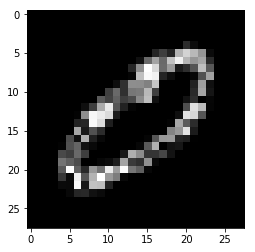

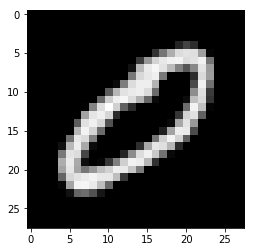

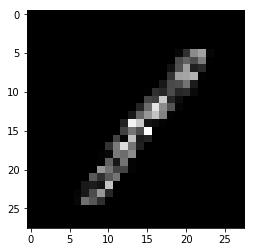

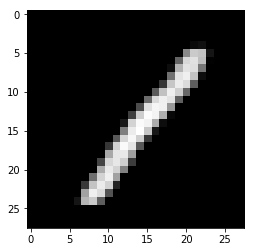

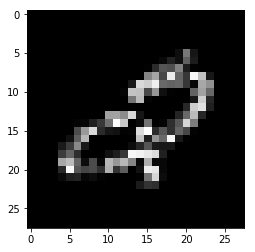

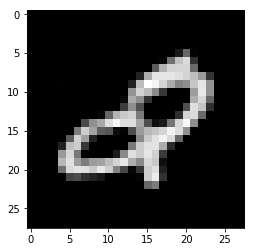

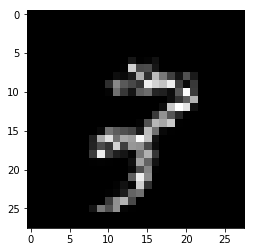

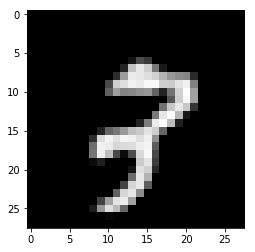

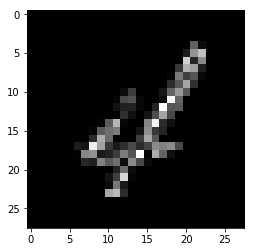

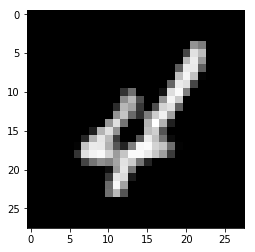

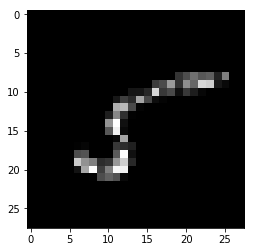

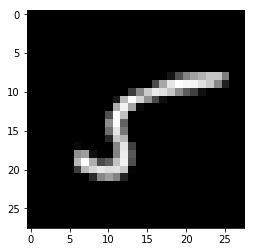

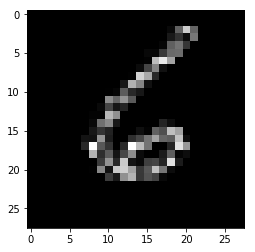

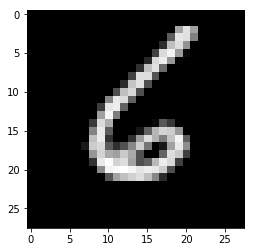

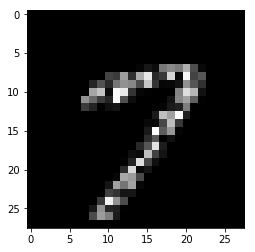

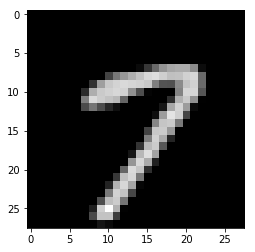

In [31]:
#test phase

encoder.load_state_dict(torch.load('./saved_data/denoising_cnn_model.ckpt'))
for i ,[t_image,t_label]in enumerate(test_loader):
    image_n=torch.mul(t_image,noise)
    t_image=Variable(t_image).cuda()
    image_n=Variable(image_n).cuda()
    t_out=encoder(image_n)
for i in range(10):
    input_image=image_n[i].cpu()
    output_image=t_out[i].cpu()
    input_image=input_image.data.numpy()
    output_image=output_image.data.numpy()
    plt.imshow(input_image[0],cmap='gray')
    plt.show()
    plt.imshow(output_image[0],cmap='gray')
    plt.show()
